In [21]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Subset
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid 
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from sklearn.model_selection import train_test_split


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
writer = SummaryWriter()

In [24]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Load datasets from disk with transforms applied
train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=train_transform, download=False)
validation_data = datasets.INaturalist(root='data/validation', version="2021_valid", transform=val_transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_data, batch_size=128, shuffle=True, num_workers=4)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [25]:
cat_list = [int(cat[1:5]) for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]
# get corresponding labels

In [26]:
bird_indices = []
with open('bird_indices.txt', 'r') as f:
    for line in f:
        bird_indices.append(int(line[0:-1]))

bird_test_indices = []
with open('bird_val_indices.txt', 'r') as f:
    for line in f:
        bird_test_indices.append(int(line[0:-1]))

In [27]:
# Find all indices where the target (label) corresponds to birds
# Create a subset dataset containing only birds
train_data_birds = Subset(train_data, bird_indices)

label_index_map = {}
index_list = [] 
label_list = []

# for i, (_, label) in enumerate(train_data_birds):
#     index_list.append(i)
#     label_list.append(label)
# # now, for each label, randomly select 20% of indices, these will become the val set. 
# index_list_train, index_list_val, labels_train, labels_val = train_test_split(
# index_list, label_list, test_size=0.2, random_state=42, stratify=label_list)

In [28]:
def read_list_from_file(file_name):
    output_list = []
    with open(file_name, 'r') as f:
        for line in f:
            output_list.append(int(line[0:-1]))
    return output_list

index_list_train = read_list_from_file("index_list_train.csv") 
index_list_val = read_list_from_file("index_list_val.csv") 
labels_train = read_list_from_file("labels_train.csv") 
labels_val = read_list_from_file("labels_val.csv") 

In [29]:
val_data_birds = Subset(train_data_birds, index_list_val)
train_data_birds = Subset(train_data_birds, index_list_train)

In [30]:

# Create a DataLoader for the filtered dataset
train_loader_birds = DataLoader(train_data_birds, batch_size=32, shuffle=True, num_workers=4)
val_loader_birds = DataLoader(val_data_birds, batch_size=32, shuffle=True, num_workers=4)

# use validation set from problem as the unseen test set
test_data_birds = Subset(validation_data, bird_test_indices)
test_loader_birds = DataLoader(test_data_birds, batch_size=32, shuffle=True, num_workers=4)

print(f"Filtered train dataset contains {len(train_data_birds)} bird images.")
print(f"Filtered val dataset contains {len(val_data_birds)} bird images.")
print(f"Filtered test dataset contains {len(test_data_birds)} bird images.")

Filtered train dataset contains 59440 bird images.
Filtered val dataset contains 14860 bird images.
Filtered test dataset contains 14860 bird images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


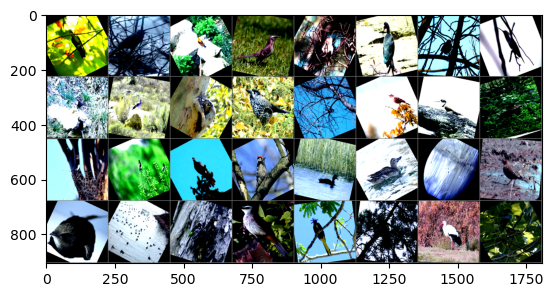

In [31]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader_birds)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

In [32]:
n_classes = len(cat_list)

In [33]:
def remap_labels(labels):
    return (labels - 3111).long()  


def log_metrics_tensor_board(data_type, accuracy, top_5_accuracy, loss, epoch ):
    writer.add_scalar(f"Loss -  {data_type}", loss, epoch)
    writer.add_scalar(f"Accuracy -  {data_type}", 100 * accuracy, epoch)
    writer.add_scalar(f"Top 5 Accuracy - {data_type}", 100 * top_5_accuracy, epoch)
    return


def save_model(model, criterion, optimizer,  epoch, model_name):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f"runs/model_{model_name}.pth")
    return


def run_epoch(model, loader, criterion, optimizer=None, epoch=0, mode="train"):
    is_train = mode == "train"
    model.train() if is_train else model.eval()

    running_loss = 0.0
    correct = 0
    top_5_correct = 0
    total = 0

    with torch.set_grad_enabled(is_train):  # Only compute gradients during training
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            # count total correct predicitions in batch
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            # count total matches of label in top 5 class predictions 
            _, top_5_predicted = outputs.topk(5, dim=1)
            top_5_correct += torch.isin(labels, top_5_predicted).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
    top_5_accuracy = top_5_correct / total
    log_metrics_tensor_board(mode, accuracy, top_5_accuracy, avg_loss, epoch)

    print(f"{mode.capitalize()} Accuracy: {100 * accuracy:.2f}%")
    print(f"Top 5 {mode.capitalize()} Accuracy: {100 * top_5_accuracy:.2f}%")
    print(f"Epoch {epoch+1} - {mode.capitalize()} Loss: {avg_loss:.4f}")
    return avg_loss, accuracy


def train_model(model, model_name, train_loader, val_loader, criterion, optimizer, epochs=5, early_stop_limit=5):
    best_val_loss = float('inf')
    early_stop_count = 0
    # lists to track of loss and accuracy metrics
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, epoch, mode="train")
        # if no val loader, evaluate stopping based on train metrics (e.g. when training on validation after training on train before evaluating on test)
        if val_loader is None:
            val_loss, val_acc = train_loss, train_acc
        else:
            val_loss, val_acc = run_epoch(model, val_loader, criterion, None, epoch, mode="validation")
        # store metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
            # save best model so far
            save_model(model, criterion, optimizer,  epoch, model_name)
        else:
            early_stop_count += 1
        if early_stop_count == early_stop_limit:
            break
    eval_metrics = {
            "train_loss": train_loss_list,
            "val_loss": val_loss_list,
            "train_acc": train_acc_list,
            "val_acc": val_acc_list
        }
    return eval_metrics

In [37]:
# efficient net model 
weights = EfficientNet_B0_Weights.DEFAULT
pretrained_model = efficientnet_b0(weights=weights)

pretrained_model.classifier = nn.Sequential(
            nn.Linear(pretrained_model.classifier[1].in_features, 2048), 
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, n_classes)  # Final output layer
)

for param in pretrained_model.parameters():
    param.requires_grad = True  # Enable fine tune training on all layers

pretrained_model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.0001, weight_decay=1e-3)


# Train the model
eval_metrics = train_model(pretrained_model, "efficientnet_b0", train_loader_birds, val_loader_birds, criterion, optimizer, epochs=100, early_stop_limit=3)

Train Accuracy: 3.32%
Top 5 Train Accuracy: 15.98%
Epoch 1 - Train Loss: 6.2135
Validation Accuracy: 12.01%
Top 5 Validation Accuracy: 34.75%
Epoch 1 - Validation Loss: 4.8160
Train Accuracy: 13.78%
Top 5 Train Accuracy: 38.03%
Epoch 2 - Train Loss: 4.6072
Validation Accuracy: 20.38%
Top 5 Validation Accuracy: 48.95%
Epoch 2 - Validation Loss: 4.0193
Train Accuracy: 23.10%
Top 5 Train Accuracy: 50.98%
Epoch 3 - Train Loss: 3.9053
Validation Accuracy: 26.90%
Top 5 Validation Accuracy: 56.10%
Epoch 3 - Validation Loss: 3.5775
Train Accuracy: 30.04%
Top 5 Train Accuracy: 59.32%
Epoch 4 - Train Loss: 3.4492
Validation Accuracy: 30.83%
Top 5 Validation Accuracy: 59.93%
Epoch 4 - Validation Loss: 3.3318
Train Accuracy: 35.27%
Top 5 Train Accuracy: 64.62%
Epoch 5 - Train Loss: 3.1312
Validation Accuracy: 33.60%
Top 5 Validation Accuracy: 62.34%
Epoch 5 - Validation Loss: 3.1776
Train Accuracy: 39.16%
Top 5 Train Accuracy: 68.16%
Epoch 6 - Train Loss: 2.9034
Validation Accuracy: 35.08%
Top 5 V

In [35]:
def create_eval_plots(eval_metrics, model_name):
    # Convert eval_metrics to a DataFrame and add an 'epoch' column
    plot_df = pd.DataFrame.from_dict(eval_metrics)
    plot_df["epoch"] = plot_df.index + 1

    # Loss Plot 
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(plot_df["epoch"], plot_df["train_loss"], label="Training Loss",
            color="darkblue", linewidth=2)
    ax.plot(plot_df["epoch"], plot_df["val_loss"], label="Validation Loss",
            color="darkgreen", linewidth=2)
    
    # styling
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Loss", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.7)
    ax.grid(axis="x", visible=False)
    ax.legend(fontsize=12)
    # save plot
    fig.savefig(f"outputs/loss_{model_name}.png", bbox_inches="tight")
    
    # Accuracy Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scale accuracy values to percentages
    plot_df["train_acc"] *= 100
    plot_df["val_acc"] *= 100
    
    # Plot training and validation accuracies
    ax.plot(plot_df["epoch"], plot_df["train_acc"], label="Training Accuracy",
            color="darkblue", linewidth=2)
    ax.plot(plot_df["epoch"], plot_df["val_acc"], label="Validation Accuracy",
            color="darkgreen", linewidth=2)
    
    # styling
    ax.set_xlabel("Epoch", fontsize=14)
    ax.set_ylabel("Accuracy (%)", fontsize=14)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", alpha=0.7)
    ax.grid(axis="x", visible=False)
    ax.legend(fontsize=12)
    # save plot
    fig.savefig(f"outputs/accuracy_{model_name}.png", bbox_inches="tight")
    plt.close("all")
    return

create_eval_plots(eval_metrics, "efficientnet_b0")

In [39]:
# Load the checkpoint
checkpoint = torch.load(f"runs/model_efficientnet_b0.pth")

# turn to function def rebuild model
# Load the pretrained EfficientNet model
trained_model = efficientnet_b0(pretrained=False) 

trained_model.classifier = nn.Sequential(
            nn.Linear(trained_model.classifier[1].in_features, 2048), 
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048, n_classes)  # Final output layer
)

for param in trained_model.parameters():
    param.requires_grad = True  # Enable fine tune training on all layers

trained_model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.0001, weight_decay=1e-3) # Use the same optimizer as before
# Load model and optimizer states
trained_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train_model(trained_model, "efficientnet_b0_final", val_loader_birds, None, criterion, optimizer, epochs=5, early_stop_limit=2)

C:\Users\Sean\AppData\Local\Temp\ipykernel_13672\1765099268.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"runs/model_efficientnet_b0.pth")


Train Accuracy: 32.11%
Top 5 Train Accuracy: 60.81%
Epoch 1 - Train Loss: 3.3083
Train Accuracy: 39.85%
Top 5 Train Accuracy: 67.86%
Epoch 2 - Train Loss: 2.8382
Train Accuracy: 46.23%
Top 5 Train Accuracy: 73.33%
Epoch 3 - Train Loss: 2.5494
Train Accuracy: 51.20%
Top 5 Train Accuracy: 77.62%
Epoch 4 - Train Loss: 2.3310
Train Accuracy: 55.35%
Top 5 Train Accuracy: 80.98%
Epoch 5 - Train Loss: 2.1363


{'train_loss': [3.3082526935044156,
  2.8381988930445847,
  2.549423032678584,
  2.3309730270857454,
  2.136316530935226],
 'val_loss': [3.3082526935044156,
  2.8381988930445847,
  2.549423032678584,
  2.3309730270857454,
  2.136316530935226],
 'train_acc': [0.32106325706594885,
  0.3984522207267833,
  0.46231493943472407,
  0.511978465679677,
  0.5534993270524899],
 'val_acc': [0.32106325706594885,
  0.3984522207267833,
  0.46231493943472407,
  0.511978465679677,
  0.5534993270524899]}

In [40]:
# evaluate on test
val_loss, val_acc = run_epoch(trained_model, test_loader_birds, criterion, None, epoch=0, mode="validation")

Validation Accuracy: 41.61%
Top 5 Validation Accuracy: 70.26%
Epoch 1 - Validation Loss: 2.7022


In [41]:
save_model(trained_model, criterion, optimizer, epoch=18, model_name="efficientnet_b0_full_train")

In [42]:
bird_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]

In [43]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = trained_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1
# turn into dataframe and sort by smallest success classes
# then create confusion matrix for all classes - find the biggest misses


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius is 40.0 %
Accuracy for class: 03112_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_cooperii is 10.0 %
Accuracy for class: 03113_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_gentilis is 0.0 %
Accuracy for class: 03114_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_nisus is 10.0 %
Accuracy for class: 03115_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_striatus is 10.0 %
Accuracy for class: 03116_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_trivirgatus is 30.0 %
Accuracy for class: 03117_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aegypius_monachus is 20.0 %
Accuracy for class: 03118_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aquila_audax is 30.0 %
Accuracy for class: 03119_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aquila_chrysaetos is 30.0 %
Accuracy for class: 03120_Animalia_Chordata_Aves

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in bird_classes}
total_pred = {classname: 0 for classname in bird_classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader_birds:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = trained_model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[bird_classes[label]] += 1
            total_pred[bird_classes[label]] += 1
# turn into dataframe and sort by smallest success classes
# then create confusion matrix for all classes - find the biggest misses


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 03111_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_badius is 60.0 %
Accuracy for class: 03112_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_cooperii is 10.0 %
Accuracy for class: 03113_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_gentilis is 0.0 %
Accuracy for class: 03114_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_nisus is 10.0 %
Accuracy for class: 03115_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_striatus is 10.0 %
Accuracy for class: 03116_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Accipiter_trivirgatus is 30.0 %
Accuracy for class: 03117_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aegypius_monachus is 30.0 %
Accuracy for class: 03118_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aquila_audax is 20.0 %
Accuracy for class: 03119_Animalia_Chordata_Aves_Accipitriformes_Accipitridae_Aquila_chrysaetos is 0.0 %
Accuracy for class: 03120_Animalia_Chordata_Aves_